In [1]:
import sys
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import random
import numpy as np
import torch
import pandas as pd
import torch
import torch.nn.functional as f
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import time
from tqdm import trange
import pandas as pd
import math
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, UnidentifiedImageError
from pathlib import Path
import torch
import glob
from huggingface_hub import HfApi, Repository
from torchvision.datasets import ImageFolder
from transformers import ViTFeatureExtractor, ViTForImageClassification, ViTConfig
from torchvision.transforms import ToTensor

In [2]:
def setup_seed(seed): 
    torch.manual_seed(seed) 
    torch.cuda.manual_seed_all(seed) 
    np.random.seed(seed) 
    random.seed(seed) 
    torch.backends.cudnn.deterministic = True
setup_seed(0)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/10243,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/10243,1), 'GB')

Using device: cuda
Tesla V100-SXM2-32GB-LS
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


## HuggingFace

In [4]:
data_dir = Path("./OCT/train")

In [5]:
ds=ImageFolder(data_dir)
test_ds = ImageFolder('./OCT/test/')
indices = torch. randperm(len(ds)).tolist()
n_val = math.floor(len(indices) * .2)
train_ds = torch.utils.data.Subset(ds, indices[:-n_val])
val_ds = torch.utils.data.Subset(ds, indices[-n_val:])

#Data Subset for tuning and experimenting
# train_ds = torch.utils.data.Subset(ds, indices[:1000])
# val_ds = torch.utils.data.Subset(ds, indices[108200:])

In [6]:
len(train_ds)

86648

In [7]:
label2id = {}
id2label = {}
for i, class_name in enumerate(ds.classes):
    label2id[class_name] = str(i)
    id2label[str(i)] = class_name

In [8]:
class ImageClassificationCollator:
    def __init__(self, feature_extractor): 
        self.feature_extractor = feature_extractor
    def __call__(self, batch):  
        encodings = self.feature_extractor([x[0] for x in batch], return_tensors='pt')   
        encodings['labels'] = torch.tensor([x[1] for x in batch], dtype=torch.long)
        return encodings

In [9]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

collator = ImageClassificationCollator(feature_extractor)
loader = {'train':DataLoader(train_ds, batch_size=32, collate_fn=collator, num_workers=8, shuffle=True),
         'validate':DataLoader(val_ds, batch_size=32, collate_fn=collator, num_workers=8)}

# model = ViTForImageClassification.from_pretrained(
#     'google/vit-base-patch16-224-in21k',
#     num_labels=len(label2id),
#     label2id=label2id,
#     id2label=id2label
# )

# Final Pretrained Model Mentioned in Paper
model = ViTForImageClassification.from_pretrained("ViT-B-Trained_OCT")

In [10]:
model
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

85801732

In [11]:
def train_model(model, dataloader, optimizer, scheduler, loss_fn, num_epochs, patience = 5, verbose = False, early_stopping=False):
    acc_dict = {'train':[],'validate':[]}
    loss_dict = {'train':[],'validate':[]}
    best_acc = 0
    phases = ['train','validate']
    since = time.time()
    y_pred = []
    y_true = []
    the_last_loss = 100
    patience = patience
    trigger_times = 0
    
    for i in trange(num_epochs):
        print('Epoch: {}/{}'.format(i+1, num_epochs))
        print('-'*10)
        for p in phases:
            running_correct = 0
            running_loss = 0
            running_total = 0
            if p == 'train':
                model.train()
            else:
                model.eval()
                
            for data in dataloader[p]:
                optimizer.zero_grad()
                image = data['pixel_values'].to(device)
                label = data['labels'].to(device)
                imageclassification = model(image)
                output = imageclassification.logits
                loss = loss_fn(output, label)
                _, preds = torch.max(output, dim = 1)
                num_imgs = image.size()[0]
                running_correct += torch.sum(preds ==label).item()
                running_loss += loss.item()*num_imgs
                running_total += num_imgs
                if p== 'train':
                    loss.backward()
                    optimizer.step()
                if p== 'validate':
                    if i == num_epochs-1:
                        y_pred.append(torch.Tensor.cpu(preds).numpy()) 
                        y_true.append(torch.Tensor.cpu(label).numpy())
                       
            epoch_acc = float(running_correct/running_total)
            epoch_loss = float(running_loss/running_total)
            
            
            acc_dict[p].append(epoch_acc)
            loss_dict[p].append(epoch_loss)
            if p == 'validate':
                if epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = model.state_dict()
                if early_stopping == True:
                    the_current_loss = validation(model, dataloader, loss_fn)
                    print('The current loss:', the_current_loss, 'The last loss:', the_last_loss)
                    if the_current_loss > the_last_loss:
                        trigger_times += 1
                        print('trigger times:', trigger_times)

                    if trigger_times >= patience:
                        print('Early stopping!\nStart to test process.')
                        time_elapsed = time.time() - since
                        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
                        print('Best val acc: {:4f}'.format(best_acc))
                        return model, acc_dict, loss_dict, y_pred, y_true
                        break

                    if the_current_loss < the_last_loss:
                        the_last_loss = the_current_loss
                        print('trigger times', trigger_times)
            
            if verbose or (i%10 == 0):
                print('Phase:{}, epoch loss: {:.4f} Acc: {:.4f}'.format(p, epoch_loss, epoch_acc))
            if scheduler:
                scheduler.step(epoch_loss)                    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val acc: {:4f}'.format(best_acc))
    
    
    return model, acc_dict, loss_dict, y_pred, y_true

In [14]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 2e-5)
lambda_func = lambda epoch: 0.5 ** epoch
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

model, acc_dict, loss_dict, y_pred, y_true = train_model(model.to(device), loader, optimizer, scheduler, loss_fn, num_epochs=5, verbose = True)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1/5
----------
Phase:train, epoch loss: 0.1723 Acc: 0.9500


 20%|██        | 1/5 [16:57<1:07:49, 1017.42s/it]

Phase:validate, epoch loss: 0.1082 Acc: 0.9652
Epoch: 2/5
----------
Phase:train, epoch loss: 0.0804 Acc: 0.9748


 40%|████      | 2/5 [33:54<50:51, 1017.03s/it]  

Phase:validate, epoch loss: 0.1161 Acc: 0.9623
Epoch: 3/5
----------
Phase:train, epoch loss: 0.0524 Acc: 0.9845


 60%|██████    | 3/5 [50:51<33:54, 1017.01s/it]

Phase:validate, epoch loss: 0.0950 Acc: 0.9708
Epoch: 4/5
----------
Phase:train, epoch loss: 0.0373 Acc: 0.9894


 80%|████████  | 4/5 [1:07:48<16:57, 1017.10s/it]

Phase:validate, epoch loss: 0.1012 Acc: 0.9698
Epoch: 5/5
----------
Phase:train, epoch loss: 0.0293 Acc: 0.9916


100%|██████████| 5/5 [1:24:45<00:00, 1017.02s/it]

Phase:validate, epoch loss: 0.1022 Acc: 0.9710
Training complete in 84m 45s
Best val acc: 0.970962


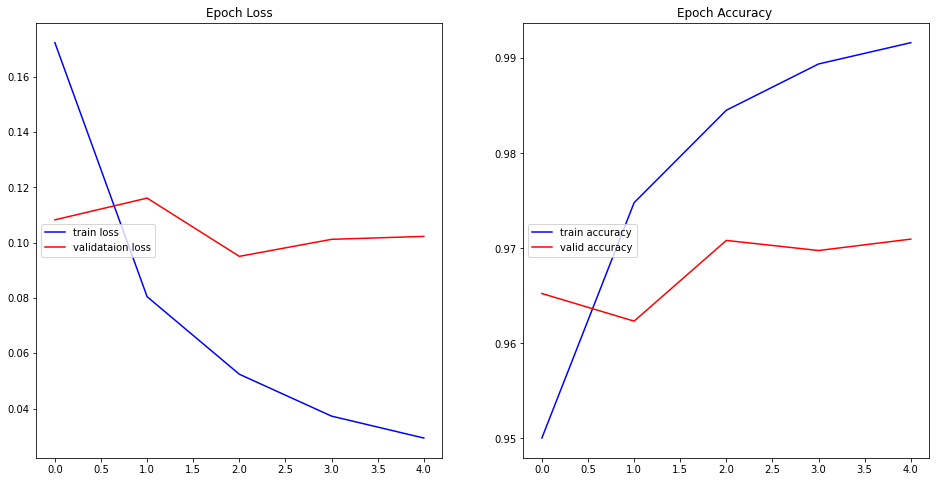

In [15]:
# Plotting loss and accuracy
fig, axs = plt.subplots(1,2,figsize=(16,8))
axs[0].plot(loss_dict['train'], color='blue', label='train loss')
axs[0].plot(loss_dict['validate'], color='red', label='validataion loss')
axs[1].plot(acc_dict['train'], color = 'blue', label='train accuracy')
axs[1].plot(acc_dict['validate'], color = 'red', label='valid accuracy')
axs[0].set_title("Epoch Loss")
axs[1].set_title("Epoch Accuracy ")
axs[0].legend(loc='center left')
axs[1].legend(loc='center left')

In [29]:
#Saving final trained model weights
# model.save_pretrained("ViT-B-Trained_OCT_Improved")

In [12]:
# model = ViTForImageClassification.from_pretrained('ViT-B-Trained_OCT')

### Test ViT Model

In [12]:
def evaluate_model(model, dataloader, loss_fn):
    model.eval()
    running_correct = 0
    running_loss = 0
    running_total = 0
    y_hat = []
    y_true = []
    
    for data in dataloader:
        image = data['pixel_values'].to(device)
        label = data['labels'].to(device)
        imageclassification = model(image)
        output = imageclassification.logits
        loss = loss_fn(output, label)
        _, preds = torch.max(output,dim = 1)
        y_hat.append(preds.cpu().numpy())
        y_true.append(label.cpu().numpy())
        num_imgs = image.size()[0]
        running_correct += torch.sum(preds ==label).item()
        running_loss += loss.item()*num_imgs
        running_total += num_imgs
        
    accuracy = float(running_correct/running_total)
    loss = float(running_loss/running_total)
    y_hat = np.concatenate(y_hat)
    y_true = np.concatenate(y_true)
    
    return accuracy, loss, y_hat, y_true

In [13]:
test_loader = DataLoader(test_ds, batch_size=32, collate_fn=collator, num_workers=8, shuffle=False)

In [14]:
loss_fn = nn.CrossEntropyLoss()
model1_acc, model1_loss, y_hat, y_true = evaluate_model(model.to(device), test_loader, loss_fn)

In [15]:
print(model1_loss)
print(f'{model1_acc*100}%')
print(y_true[:10])
print(y_hat[:10])

0.0997178371977061
96.89999999999999%
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]


In [16]:
def ROC_curve(y_test,y_score):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = y_test.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    lw = 2
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='ROC curve of class {0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")
    plt.show()
    return None


In [17]:
# Plot ROC
classes = range(len(np.unique(y_hat)))

def label_binarize_classes(classes, a):
    label_class = []
    for label in classes:
        if label == a:
            label_class.append(1)
        else:
            label_class.append(0)
    return label_class

for i in classes:
    true_labels_test = label_binarize_classes(y_true, i)
    pred_labels_test = label_binarize_classes(y_hat, i)
    fpr, tpr, thresholds = roc_curve(true_labels_test, pred_labels_test)
    auc = roc_auc_score(true_labels_test, pred_labels_test)

    print('Class ' + str(i),'=','AUC ' + str(auc))
    
    plt.figure(figsize=(10,4))
    plt.title('ROC Curve Class '+str(i))
    plt.plot(fpr,tpr,color ='blue')
    plt.plot([0,1],[0,1],"k--")
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')

NameError: name 'roc_curve' is not defined

In [20]:
# Confusion Matrix
from sklearn.metrics import  confusion_matrix, roc_curve, auc
import itertools  

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
def cm(y_true, y_pred):
    cnf_matrix = confusion_matrix(y_true, y_pred)
    np.set_printoptions(precision=2)
    plt.figure()
    class_names = ['0: CNV','1: DME','2: DRUSEN','3: Normal']
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix')

Normalized confusion matrix
[[1.   0.   0.   0.  ]
 [0.01 0.99 0.   0.  ]
 [0.08 0.   0.9  0.01]
 [0.   0.   0.01 0.99]]


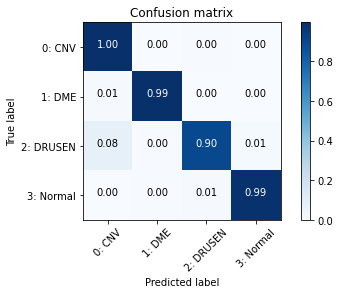

In [21]:
# Confusion Matrix for CNN_model_CXR0
cm(y_true, y_hat)

In [18]:
from sklearn.metrics import classification_report
class_names = ['0: CNV','1: DME','2: DRUSEN','3: Normal']

classificationreport = classification_report(y_true, y_hat, target_names = class_names)
print(classificationreport)

              precision    recall  f1-score   support

      0: CNV       0.92      1.00      0.95       250
      1: DME       0.99      0.99      0.99       250
   2: DRUSEN       0.99      0.90      0.94       250
   3: Normal       0.99      0.99      0.99       250

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000

